In [1]:
input_file_path = f"Files/nycyellotaxi-backup"
output_path = "Files/parquet-to-delta-table-fabric"
keywords_to_be_considered =['2022']
no_of_parallel_jobs = 4


StatementMeta(, , , Waiting, , Waiting)

In [14]:
from notebookutils import mssparkutils
_input_files_path =   mssparkutils.fs.ls(f"{input_file_path}")
input_files_path = []
for fileinfo in _input_files_path:
    input_files_path.append(fileinfo.path)

files_path = []
filtered_list_of_path = []
for keyword in keywords_to_be_considered:
    filtered_list_of_path = [i for i in input_files_path if keyword in i]
    for f in filtered_list_of_path:
        files_path.append(f)

StatementMeta(, , , Waiting, , Waiting)

In [15]:
len(files_path)

StatementMeta(, , , Waiting, , Waiting)

12

In [16]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

StatementMeta(, , , Waiting, , Waiting)

In [17]:
files_list_part = chunkIt(files_path, no_of_parallel_jobs)

StatementMeta(, , , Waiting, , Waiting)

In [18]:
DAG={}
activities = []
for i in range(0, no_of_parallel_jobs):
    activity = {"name": f"childNotebookcall-{i}", "timeoutPerCellInSeconds": 90000 , "path": "/child_notebook_parallelism", "args": {"files_list_part": f"{files_list_part[i]}", "output_path" : f"{output_path}/temp/batch{i}"}}
    activities.append(activity)
DAG["activities"]= activities

StatementMeta(, , , Waiting, , Waiting)

StatementMeta(, , , Waiting, , Waiting)

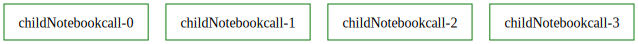

{'childNotebookcall-0': {'exitVal': '', 'exception': None},
 'childNotebookcall-1': {'exitVal': '', 'exception': None},
 'childNotebookcall-2': {'exitVal': '', 'exception': None},
 'childNotebookcall-3': {'exitVal': '', 'exception': None}}

In [ ]:
mssparkutils.notebook.runMultiple(DAG, {"displayDAGViaGraphviz": True})

In [20]:
table_delta_file_location = f"Tables/test2_merge"
table_full_name = "test2_merge"
merge_join_condition = "source.hash_key = target.hash_key"

StatementMeta(, , , Waiting, , Waiting)

In [21]:
def create_delta_table(
    df,
    table_full_name,
    table_delta_file_location
):
    isDeltaTableAlreadyPresent = 0
    try:
        mssparkutils.fs.ls(table_delta_file_location)
        isDeltaTableAlreadyPresent = 1
    except:
    #writing the delta table into the curated location
        df.write.format("delta").mode("overwrite").save(table_delta_file_location)
        sqltext = f"CREATE TABLE IF NOT EXISTS {table_full_name} USING DELTA LOCATION '{table_delta_file_location}'"
        # print(sqltext)
        spark.sql(sqltext)
    return  isDeltaTableAlreadyPresent

StatementMeta(, , , Waiting, , Waiting)

In [22]:
def mergeDeltaTable(
    table_full_name,
    df,
    merge_join_condition
):
    df.createOrReplaceTempView("temp_vw_new_data")
    sqltext = (f'''

    MERGE INTO {table_full_name} as source
    USING temp_vw_new_data as target
    ON {merge_join_condition}    
    WHEN MATCHED THEN UPDATE SET *
    WHEN NOT MATCHED THEN INSERT *

    
    
    ''')
    # print(sqltext)
    spark.sql(sqltext)

StatementMeta(, , , Waiting, , Waiting)

In [23]:
import time
import timeit
import functools
from pyspark.sql import DataFrame
from pyspark.sql.functions import expr, col
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

start_time = time.time()
output_dfs = []
for i in range(0, no_of_parallel_jobs):
    input_path = f"{output_path}/temp/batch{i}"
    df = spark.read.parquet(input_path)
    output_dfs.append(df)
df_output = functools.reduce(DataFrame.unionAll, output_dfs)
windowSpec = Window.partitionBy("hash_key").orderBy("hash_key")
df_output = df_output.withColumn("row_num", row_number().over(windowSpec)).filter("row_num=1")
df_output = df_output.drop("row_num")
isDeltaTableAlreadyPresent = create_delta_table(
        df=df_output,
        table_full_name=table_full_name,
        table_delta_file_location=table_delta_file_location
)
print (f"isDeltaTableAlreadyPresent = {isDeltaTableAlreadyPresent} [[ 0= Not Present, so we created the delta table. 1= present ]], we skip creatioon of the delta table")
if (isDeltaTableAlreadyPresent==1):
    print(" We are going to merge the new dataframe with the delta table")
    mergeDeltaTable(
            merge_join_condition=merge_join_condition,
            df=df_output,
            table_full_name=table_full_name
    )
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time}")

StatementMeta(, , , Waiting, , Waiting)

isDeltaTableAlreadyPresent = 1 [[ 0= Not Present, so we created the delta table. 1= present ]], we skip creatioon of the delta table
 We are going to merge the new dataframe with the delta table


Execution time: 435.84950375556946


In [24]:
%%sql

select count(*) from test2_merge

StatementMeta(, , , Waiting, , Waiting)

<Spark SQL result set with 1 rows and 1 fields>